## Housing, Health & Happiness - Creative Extension

### I. Importing Libraries and Data

In [11]:
### Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas.util.testing as tm
import seaborn as sns

### Import data

DATA_FOLDER = 'Data/'

# NaN values are replaced with 0, as described in the paper 
# SHOULD WE DROP NaN VALUES OR PUT THEM TO 0 ? IT CHANGES THE VALUE FOR THE MEAN !!

household_data = pd.read_stata(DATA_FOLDER + 'PisoFirme_AEJPol-20070024_household.dta').dropna()
individual_data = pd.read_stata(DATA_FOLDER + 'PisoFirme_AEJPol-20070024_individual.dta').dropna()

In [12]:
print('treatment:', len(household_data[household_data['dpisofirme'] == 1]))
print('control:', len(household_data[household_data['dpisofirme'] == 0]))

treatment: 936
control: 1017


### II. Is the original matching truly balanced ? 

> In the paper 'Housing, Health, and Happiness', the treatment and control group are matched according to the variables C_blockdirtfloor, C_HHdirtfloor, C_child05 and C_households. The paper claims that these 4 variables are balances, according to Table 2 where the means for treatment and control are computed, along with standard errors and the mean difference. Let us verify with statistical tests that this is indeed the case.  

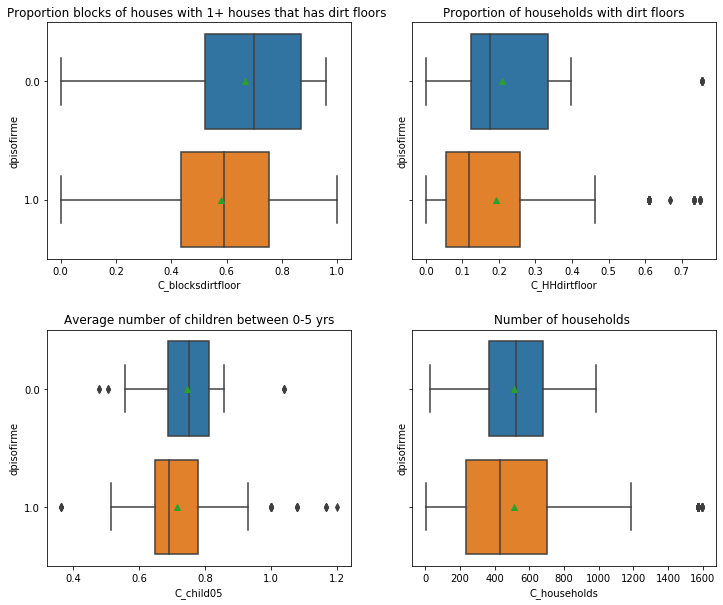

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
fig.subplots_adjust(hspace=0.3)

sns.boxplot(ax=axes[0,0], x=household_data['C_blocksdirtfloor'], y=household_data['dpisofirme'], showmeans=True, orient='h');
axes[0,0].set_title('Proportion blocks of houses with 1+ houses that has dirt floors ')

sns.boxplot(ax=axes[0,1], x=household_data['C_HHdirtfloor'], y=household_data['dpisofirme'], showmeans=True, orient='h');
axes[0,1].set_title('Proportion of households with dirt floors');

sns.boxplot(ax=axes[1,0], x=household_data['C_child05'], y=household_data['dpisofirme'], showmeans=True, orient='h');
axes[1,0].set_title('Average number of children between 0-5 yrs');

sns.boxplot(ax=axes[1,1], x=household_data['C_households'], y=household_data['dpisofirme'], showmeans=True, orient='h');
axes[1,1].set_title('Number of households ');

In [14]:
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import levene
from scipy.stats import ttest_ind

# Levene test verifies the null hypothesis that all input samples are from populations with equal variances.

# The t-test verifies the null hypothesis that 2 independent samples have identical average (expected) values. 
# This test assumes that the populations have identical variances by default, but we define as False if the 
# variances are not equal (known as Welch's t-test). 

df = pd.DataFrame(columns = household_data.columns).reset_index()
df['index'] = ['T-test', 'Identical Mean']

for col in household_data:
    
    a = household_data[col][household_data['dpisofirme'] == 1]
    b = household_data[col][household_data['dpisofirme'] == 0]
    ttest = ttest_ind(a, b, equal_var = False, nan_policy = 'omit')
    if (ttest.pvalue < 0.05):
        identical_mean = False
    else:
        identical_mean = True
        
    df[col] = pd.Series([ttest.pvalue, identical_mean])
    
df = df.drop(df.columns[[1, 2, 3, 4, 5, 6]], axis = 1)
df

,index,C_blocksdirtfloor,C_HHdirtfloor,C_child05,C_households,C_people,C_rooms,C_HHpersons,C_waterland,C_waterhouse,...,S_cesds,S_pss,S_instcement,S_instsanita,S_restsanita,S_constceili,S_restowalls,S_improveany,S_logrent,S_logsell
0,T-test,4.53646e-18,0.0144944,1.70607e-12,0.988007,0.400063,0.0134354,3.71459e-23,3.34897e-16,8.71024e-11,...,1.79029e-07,4.63368e-07,4.12629e-78,0.512149,0.824003,0.342723,0.412259,0.0648689,0.338063,0.599255
1,Identical Mean,False,False,False,True,True,False,False,False,False,...,False,False,False,True,True,True,True,True,True,True


> It appears that the mean values for 3 of the 4 variables used for the matching are not balanced, as the statistical test yields a p-value below the threshold of 0.05, indicating that we must reject the null hypothesis of equal averages.

In [15]:
# Looking at the mean values 
np.mean(household_data['C_blocksdirtfloor'][household_data['dpisofirme'] == 1])
np.std(household_data['C_blocksdirtfloor'][household_data['dpisofirme'] == 1])

0.2158486396074295

### III. Benchmarking
> Omitted variable bias can affect treatment effect estimates obtained from observational data due to the lack of random assignment to treatment groups. Sensitivity analyses adjust these estimates to quantify the impact of potential omitted variables.
> As a first step of sensitivity analysis, one can use benchmarking: the use of data to establish reference points for speculation about omitted confounders.

In [16]:
### Creating a Dataframe for the data

R2_df = pd.DataFrame(columns = ['Total Model 3', 'C(dpisofirme)', 'S_HHpeople', 'S_headage','S_spouseage','S_headeduc',\
                                'S_spouseeduc', 'S_dem1','S_dem2','S_dem3','S_dem4','S_dem5','S_dem6','S_dem7','S_dem8',\
                                'C(S_waterland)','C(S_waterhouse)','C(S_electricity)','C(S_hasanimals)','C(S_animalsinside)',\
                                'C(S_garbage)', 'S_washhands', 'S_cashtransfers', 'C(S_milkprogram)', 'C(S_foodprogram)',\
                                'C(S_seguropopular)']).reset_index()
R2_df['index'] = ['Share of rooms with cement floors', 'Cement floor in kitchen',\
                  'Cement floor in dining room', 'Cement floor in bathroom', 'Cement floor in bedroom']

In [17]:
def create_mod_str(x,z):
    output_str = ''
    for i in range(0,len(x)):
        if((i != z) and (i != len(x)-1)):
            output_str = output_str + x[i] + ' + '
        if(i == len(x)-1):
            output_str = output_str + x[i]
    return output_str

In [18]:
### Omitted variable bias 

# We begin by looking at the effect of regressors on R^2. We can look at each variable of the models and see 
# the change incurred in R^2 when the regressors are not included in the model. This enables a classification 
# of the most predictive regressors in terms of R^2. Indeed, the difference in R^2 corresponds to the bias 
# that would have been incurred by omitting said variable in the model. 

# Looking at Model 3 for Table 4 of the paper
mod_variables = ['S_shcementfloor', 'S_cementfloorkit', 'S_cementfloordin', 'S_cementfloorbat', 'S_cementfloorbed']
mod_regressors = ['C(dpisofirme)', 'S_HHpeople', 'S_headage','S_spouseage','S_headeduc',\
                  'S_spouseeduc', 'S_dem1','S_dem2','S_dem3','S_dem4','S_dem5','S_dem6','S_dem7','S_dem8',\
                  'C(S_waterland)','C(S_waterhouse)','C(S_electricity)','C(S_hasanimals)','C(S_animalsinside)',\
                  'C(S_garbage)', 'S_washhands', 'S_cashtransfers', 'C(S_milkprogram)', 'C(S_foodprogram)',\
                  'C(S_seguropopular)']
model3 = 'C(dpisofirme) + S_HHpeople + S_headage + S_spouseage + \
                     S_headeduc + S_spouseeduc + S_dem1 + S_dem2 + S_dem3 + S_dem4 + S_dem5 + S_dem6 + S_dem7 \
                     + S_dem8 + C(S_waterland) + C(S_waterhouse) + C(S_electricity) + C(S_hasanimals) + \
                     C(S_animalsinside) + C(S_garbage) + S_washhands + S_cashtransfers + C(S_milkprogram) +\
                     C(S_foodprogram) + C(S_seguropopular)'

for i in range(0,5):
    
    # Declaring Model
    mod = smf.ols(formula = mod_variables[i] + ' ~ ' + model3, data = household_data)

    # Fitting Model
    np.random.seed(2)
    res = mod.fit(cov_type = 'cluster', cov_kwds={'groups': household_data['idcluster']})
    R2 = res.rsquared
    R2_df['Total Model 3'].iloc[i] = R2
    
    for j in range(len(mod_regressors)):
    
        # Declaring the Model
        mod = smf.ols(formula = mod_variables[i] + ' ~ ' + create_mod_str(mod_regressors,j), data = household_data)

        # Fitting Model
        np.random.seed(2)
        res = mod.fit(cov_type = 'cluster', cov_kwds={'groups': household_data['idcluster']})
        R2 = res.rsquared
        R2_df[mod_regressors[j]].iloc[i] = 100*((1-R2_df['Total Model 3'].iloc[i])-(1-R2))/(1-R2_df['Total Model 3'].iloc[i])

R2_df

,index,Total Model 3,C(dpisofirme),S_HHpeople,S_headage,S_spouseage,S_headeduc,S_spouseeduc,S_dem1,S_dem2,...,C(S_waterhouse),C(S_electricity),C(S_hasanimals),C(S_animalsinside),C(S_garbage),S_washhands,S_cashtransfers,C(S_milkprogram),C(S_foodprogram),C(S_seguropopular)
0,Share of rooms with cement floors,0.191436,-12.577,-0.139664,-0.0175988,-0.116439,-0.851833,-0.140487,-0.182894,-0.182894,...,-3.33702,-0.040927,-0.000345283,-0.303903,-0.0230077,-0.240234,-0.386402,-0.0138074,-0.142328,0
1,Cement floor in kitchen,0.160218,-10.7844,-0.150145,-0.101374,-0.0832466,-0.842367,-0.0206583,-0.139544,-0.139544,...,-1.92829,-0.0112984,-0.0774852,-0.311298,-0.0170976,-0.465529,-0.464647,-0.000312398,-0.135859,0
2,Cement floor in dining room,0.121382,-6.97457,-0.0841506,-0.0441213,-0.0941154,-0.742093,-0.000285113,-0.04321,-0.0432099,...,-2.35313,-7.1063e-05,-0.129668,-0.0223909,-0.0121926,-0.0446802,-0.520073,-0.0191608,-0.366645,0
3,Cement floor in bathroom,0.103935,-2.42447,-0.00519141,-0.0234638,-0.000375562,-0.274399,-0.320627,-0.115851,-0.115851,...,-2.42506,-0.198769,-0.211829,-0.139238,-0.850722,-0.289275,-0.100393,-0.128819,-0.140185,0
4,Cement floor in bedroom,0.128028,-7.70551,-0.966456,-0.0703675,-0.162837,-0.692933,-0.0322654,-0.168201,-0.168201,...,-0.755384,-0.0228567,-0.0174011,-0.305894,-0.00547268,-0.020943,-0.00968016,-0.0128562,-0.00101557,0


In [19]:
from plotly import graph_objs as go

variables = R2_df['index']
counter=0;

fig = go.Figure()

for vb in variables:
    
    trace = go.Bar(x=R2_df.columns, y=R2_df.iloc[counter], name=vb)
    
    fig.add_trace(trace)
    
    counter=counter+1

fig.update_layout(
    {'title_text': '$R^2$ bias',
        'xaxis': dict(title='Regressors', tickangle=45),
        'yaxis_title_text': '$R^2$ values',
        "width": 1000, "height": 700,
        "autosize": True})
fig.show()

### IV. Propensity score matching
> To remedy the matching issues, one can use the propensity score in order to match treatment and control groups.

In [54]:
### Defining the formulas for the regression models (LHS and RHS)

# LHS represents the 5 studied variables

mod_formula_lhs = ['S_shcementfloor', 'S_cementfloorkit', 'S_cementfloordin', 'S_cementfloorbat', 'S_cementfloorbed']

# RHS represents the control variables for the 3 models
  # Model 1: no controls
  # Model 2: age, demographic, health habits controls
  # Model 3: age, demographic, health habits, and public social programs controls

mod_formula_rhs = ['C(dpisofirme)', 'C(dpisofirme) + S_HHpeople + S_headage + S_spouseage + \
                     S_headeduc + S_spouseeduc + S_dem1 + S_dem2 + S_dem3 + S_dem4 + S_dem5 + S_dem6 + S_dem7 \
                     + S_dem8 + C(S_waterland) + C(S_waterhouse) + C(S_electricity) + C(S_hasanimals) + \
                     C(S_animalsinside) + C(S_garbage) + S_washhands', 'C(dpisofirme) + S_HHpeople + S_headage + S_spouseage + \
                     S_headeduc + S_spouseeduc + S_dem1 + S_dem2 + S_dem3 + S_dem4 + S_dem5 + S_dem6 + S_dem7 \
                     + S_dem8 + C(S_waterland) + C(S_waterhouse) + C(S_electricity) + C(S_hasanimals) + \
                     C(S_animalsinside) + C(S_garbage) + S_washhands + S_cashtransfers + C(S_milkprogram) +\
                     C(S_foodprogram) + C(S_seguropopular)'] 

# N.B. : the variable S_rooms is not included (number of rooms in the house), as it was not included in the Stata code
# provided. The variable is said to be used in the Models 2 and 3 in the paper, but the regressions yield better results
# in terms of replication when it is not included. 

In [55]:
### Declare Model

mod = smf.ols(formula = mod_formula_lhs[1] + ' ~ ' + mod_formula_rhs[1], data=household_data)

### Fit Model

np.random.seed(2)
res = mod.fit()

### Propensity score

household_data['Propensity_score'] = res.predict()   